In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

## Dataset

In [23]:
# Dataclass for adding problem

class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [24]:
n_data = 1000
t_steps = 10

data,labels = datagen_full_sum_normal(n_data,t_steps,normalize=True)
# data,labels = datagen_timewise_labels(n_data,t_steps,2)
# print(data[1],labels[1])

BATCH_SIZE = 16

training_data = Datamodel(data,labels)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

data.shape

print(data[100].sum())

tensor(1.0000)


## Model training

Guess on the first 15 training data:  tensor([0.4990, 0.4981, 0.5047, 0.5007, 0.5037, 0.4982, 0.5052, 0.5011, 0.4989,
        0.5029, 0.5017, 0.5013, 0.4998, 0.5011, 0.4984],
       grad_fn=<SigmoidBackward0>)


100%|██████████| 300/300 [00:55<00:00,  5.41it/s]


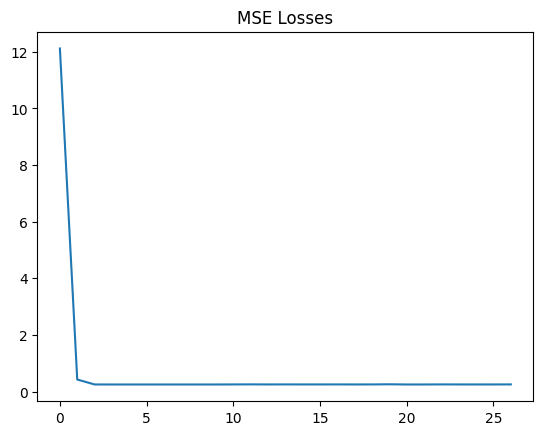

Guess on the first 15 training data:  tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       grad_fn=<SigmoidBackward0>)


In [25]:
hidden_size = 100
input_size = 1
output_size = 1

train1 = True

if train1:
    # model2 = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.01,irnn=True,outputnn=False,Wx_normalize=True)
    # model1 = torch_RNN_full_manual(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False,outputnn=True,Wx_normalize=False,activation=False)
    model1 = RNN_L2(input_size,t_steps,output_size,hidden_size,lr=0.001,w_decay=0.000,act_decay=1000,irnn=False,outputnn=True,Wx_normalize=False,activation=False)
    print("Guess on the first 15 training data: ", model1(data[0:15]))
    _ = model1.train(training_loader,epochs=300)
    model1.plot_losses(average=30)
    # model1.plot_accs()
    print("Guess on the first 15 training data: ", model1(data[0:15]))
    # print("Weight of the hidden layer: ",model2.rnn.weight_hh_l0, " Weight of the input layer: ",model2.rnn.weight_ih_l0)

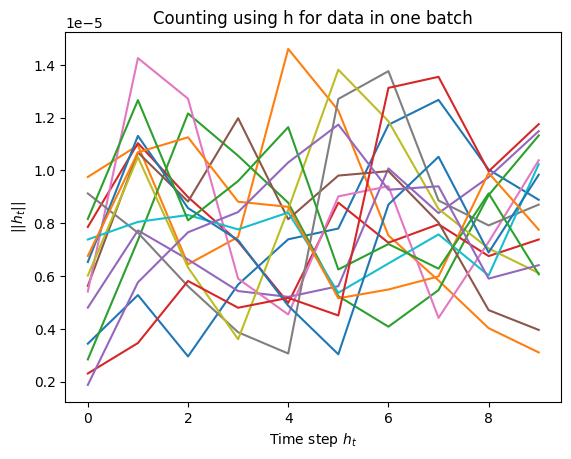

In [26]:
model1.hts.norm(dim=2).shape
htss = model1.hts.norm(dim=2)
plt.plot(htss.detach().numpy())
plt.title("Counting using h for data in one batch")
plt.xlabel(r"Time step $h_t$")
plt.ylabel(r"$||h_t||$")
plt.show()

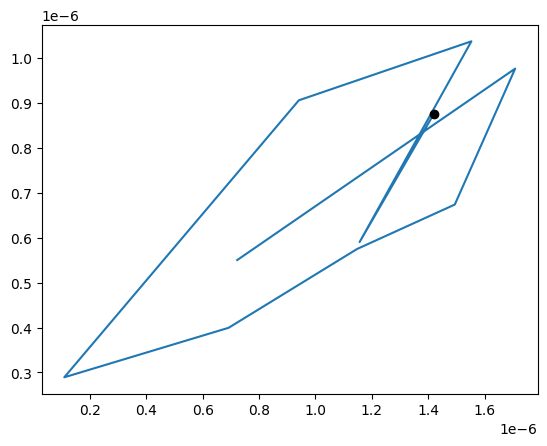

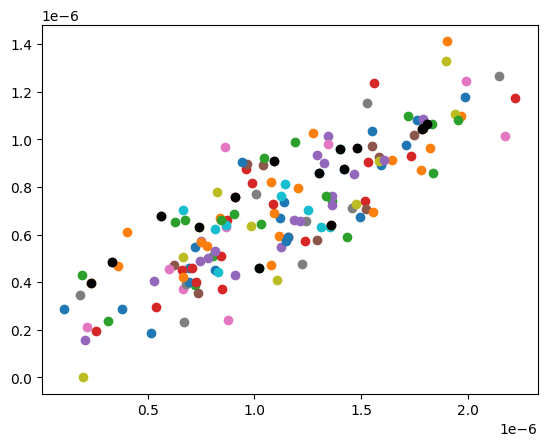

In [27]:
n = 10
model1.hts[:,n,:].shape
hts_cric = model1.hts.detach().numpy()
plt.plot(hts_cric[:,n,0],hts_cric[:,n,1],"-")
plt.plot(hts_cric[-1,n,0],hts_cric[-1,n,1],"o",color="black")
plt.show()
plt.plot(hts_cric[:,:,0],hts_cric[:,:,1],"o")
plt.plot(hts_cric[-1,:,0],hts_cric[-1,:,1],"o",color="black")
plt.show()

In [28]:
print(model1.input.weight)
print(model1.hidden.weight)
print(model1.output.weight)

Parameter containing:
tensor([[ 5.8793e-06],
        [ 4.4794e-06],
        [-1.2527e-05],
        [ 1.2605e-05],
        [ 1.0561e-06],
        [ 7.8507e-07],
        [-9.7972e-07],
        [-1.3273e-05],
        [ 1.0161e-06],
        [-2.5299e-06],
        [ 1.0056e-05],
        [ 4.0082e-06],
        [ 8.7319e-06],
        [ 1.7900e-08],
        [-5.7930e-07],
        [ 3.8902e-06],
        [ 5.7069e-06],
        [ 1.5413e-07],
        [-8.4145e-06],
        [ 2.8893e-06],
        [-4.0583e-06],
        [-4.3261e-06],
        [ 4.2550e-06],
        [ 1.6856e-06],
        [-1.6116e-06],
        [ 7.7591e-06],
        [ 8.0041e-07],
        [ 7.3547e-06],
        [-2.8976e-06],
        [ 2.6929e-06],
        [-8.3481e-06],
        [-2.3100e-06],
        [-8.9712e-06],
        [ 6.8126e-07],
        [-5.0263e-06],
        [-6.2511e-07],
        [ 4.7421e-06],
        [-5.7309e-06],
        [-1.6306e-05],
        [ 3.5661e-06],
        [ 1.5131e-05],
        [-3.2868e-06],
        [ 1.

In [29]:
# hc = 0
# for h in model2.hts[0][0]:
#     hc += h

# np.linalg.norm(model2.hts[0,0].detach().numpy())
an1 = model1.hts[:,3,:]
an1 = an1.detach().numpy()
print(an1.shape)

for i in range(1,len(an1)):
    an1_i_normalized = an1[i]/np.linalg.norm(an1[i])
    an1_i_minus_1_normalized = an1[i-1]/np.linalg.norm(an1[i-1])
    # print(an1_i_normalized @ an1_i_minus_1_normalized)
    # Angle between an1[i] and an1[i-1]
    ang = np.arccos(an1_i_normalized @ an1_i_minus_1_normalized)
    print(np.rad2deg(ang))

(10, 100)
31.038095
18.92689
16.645422
16.73775
36.122856
43.668274
41.505833
34.910244
29.905773


In [30]:
# SVD of the weight matrix Wh

Wh = model1.hidden.weight.detach().numpy()
U, s, Vh = np.linalg.svd(Wh)
print("Singular values of Wh: ",s)

np.prod(s)
np.linalg.det(Wh)

Singular values of Wh:  [5.0539727e+00 1.2301209e+00 1.1327207e+00 1.1173532e+00 1.0601016e+00
 1.0381098e+00 9.8804945e-01 9.7118723e-01 9.5642561e-01 9.4153166e-01
 9.3125701e-01 9.1558665e-01 9.0093660e-01 8.7123150e-01 8.5666490e-01
 8.5434967e-01 8.3689439e-01 8.3210409e-01 8.2503635e-01 8.1435657e-01
 7.8763521e-01 7.7830195e-01 7.6444614e-01 7.4859470e-01 7.3921031e-01
 7.2976774e-01 7.0976579e-01 6.9888788e-01 6.8945992e-01 6.7819703e-01
 6.6035402e-01 6.5674657e-01 6.5094942e-01 6.3374031e-01 6.3330251e-01
 6.1701715e-01 6.0585773e-01 5.8669198e-01 5.8074659e-01 5.7211429e-01
 5.5851305e-01 5.5283195e-01 5.4416668e-01 5.3644258e-01 5.2788252e-01
 5.1476854e-01 5.0482148e-01 4.9246603e-01 4.7757679e-01 4.7654104e-01
 4.6733671e-01 4.5957872e-01 4.5113513e-01 4.3542174e-01 4.3163607e-01
 4.2364833e-01 4.1602448e-01 3.9613292e-01 3.7517539e-01 3.6292693e-01
 3.6015809e-01 3.4700206e-01 3.3873120e-01 3.3205137e-01 3.1999648e-01
 3.1280226e-01 3.0214405e-01 2.9856154e-01 2.9317060e

1e-45

In [31]:
# Sjekker om Wh beholder normen til x 
x = np.random.uniform(size=2)
# x_const = np.ones((100,100))
x_const = np.random.uniform(size=(100,2))
print("Norm av input:", np.linalg.norm(x))
print("Norm av Wh-skalert input",np.linalg.norm(Wh @ x), "ratio:", np.linalg.norm(Wh @ x)/np.linalg.norm(x))
# Finner utviklingen av normen av Wh-skalert input
for i in range(1,100):
    Wx = model1.input.weight.detach().numpy()
    Wx_norm = np.linalg.norm(Wx)
    x_const[i] = np.linalg.matrix_power(Wh,i) @ x_const[i]
    # x_const[i] = np.linalg.matrix_power(Wh,i) @ Wx.squeeze()*x[i]
    # x_const[i] = Wx_norm**i* Wh**i @ x_const[i]
plt.imshow(x_const)
pcm = plt.pcolor(x_const, norm = "log")
plt.colorbar(pcm)
# plt.colorbar()
plt.xlabel("Dimensjon")
plt.ylabel("Wh^i@x")
plt.show()

Norm av input: 0.904681367878486


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 100)

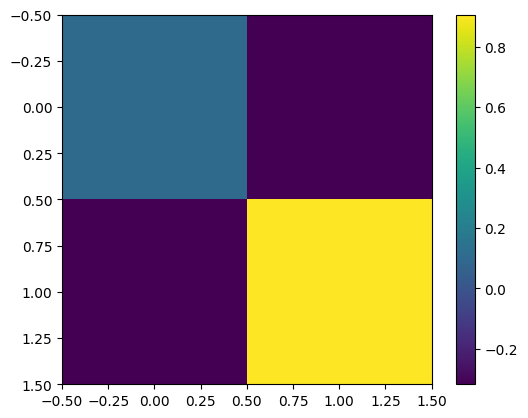

In [ ]:
plt.imshow(Wh)
plt.colorbar()

In [ ]:
Wx = model1.input.weight.detach().numpy()
print("Norm of Wx: ",np.linalg.norm(Wx))

Norm of Wx:  0.962484
